# Auto Insurance Pricing — Regression Analysis
**Goal:** Predict insurance `cost` and understand which factors drive pricing (age, car, coverage, region, etc.).


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split


## 1) Load Dataset
We load the cleaned dataset and inspect columns, missing values, and basic distributions.


In [5]:
df = pd.read_csv("/Users/sadiatasnim/Downloads/Allstate-cost-cleaned.csv")  # put file in same folder OR update path
print(df.shape)
display(df.head())
display(df.describe(include="all").T.head(20))

print(df.isna().sum().sort_values(ascending=False).head(15))


(15483, 20)


,Unnamed: 0,state,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,0,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,0,0,1,1,0,0,4,543
1,1,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,2,1,1,3,1,3,2,611
2,2,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,691
3,3,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,695
4,4,AR,1,0,4,d,4.0,26,26,0,3.0,1.0,1,0,1,1,0,2,2,628


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,15483.0,NaN,NaN,NaN,7741.0,4469.701444,0.0,3870.5,7741.0,11611.5,15482.0
state,15483,36,FL,2398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group_size,15483.0,NaN,NaN,NaN,1.230705,0.454344,1.0,1.0,1.0,1.0,4.0
homeowner,15483.0,NaN,NaN,NaN,0.532713,0.498945,0.0,0.0,1.0,1.0,1.0
car_age,15483.0,NaN,NaN,NaN,8.049926,5.719131,0.0,3.0,7.0,11.0,48.0
car_value,15435,9,e,5160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
risk_factor,15483.0,NaN,NaN,NaN,1.58955,1.521847,0.0,0.0,1.0,3.0,4.0
age_oldest,15483.0,NaN,NaN,NaN,45.84286,17.309744,18.0,30.0,45.0,60.0,75.0
age_youngest,15483.0,NaN,NaN,NaN,43.51127,17.46141,16.0,27.0,42.0,58.0,75.0
married_couple,15483.0,NaN,NaN,NaN,0.206032,0.404467,0.0,0.0,0.0,0.0,1.0


car_value            48
Unnamed: 0            0
duration_previous     0
G                     0
F                     0
E                     0
D                     0
C                     0
B                     0
A                     0
C_previous            0
state                 0
married_couple        0
age_youngest          0
age_oldest            0
dtype: int64


## 2) Exploratory Data Analysis (EDA)
We explore how `cost` changes with numeric variables and compare distributions across key categories (state, car_value, coverage).


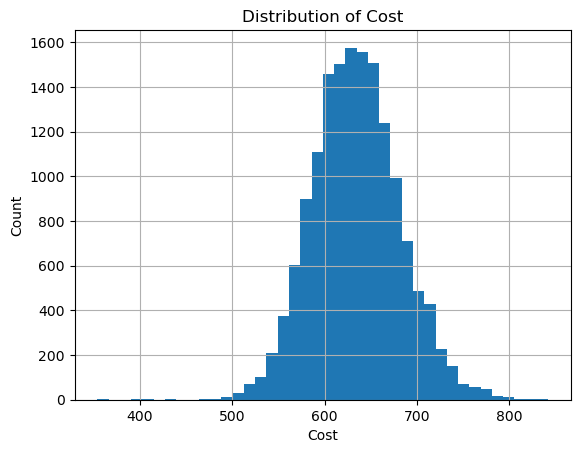

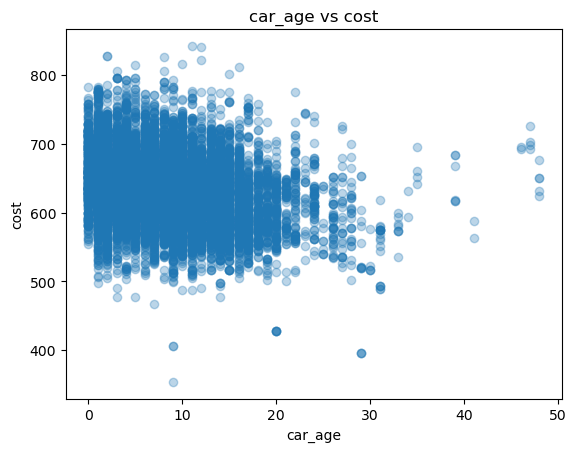

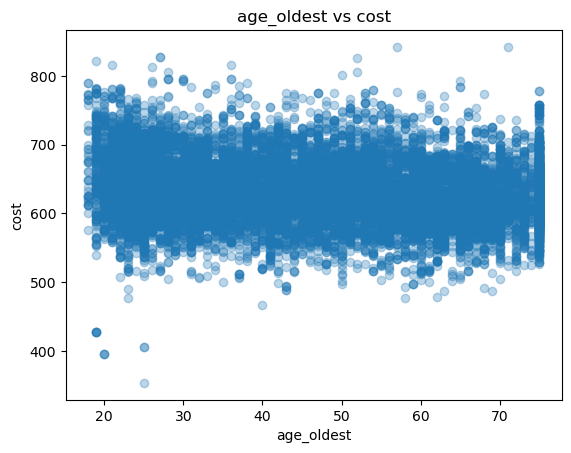

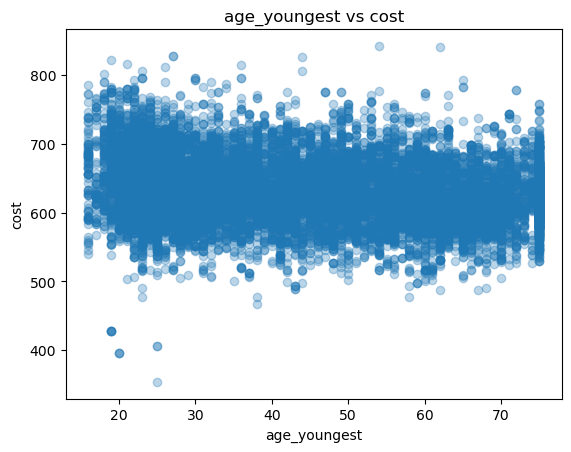

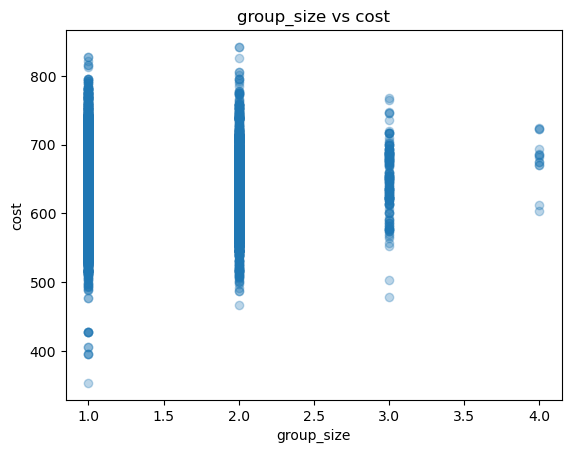

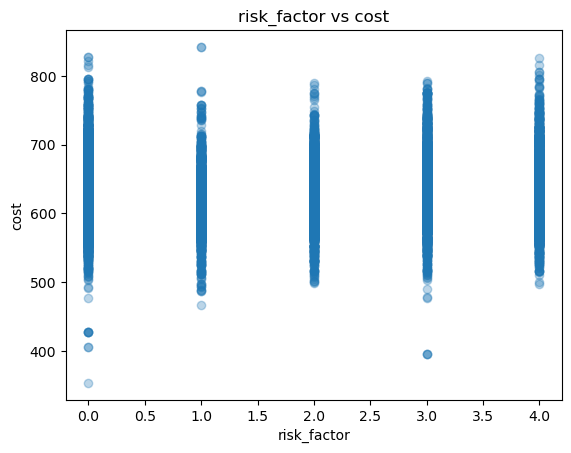

In [8]:
target = "cost"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]

# Quick hist of target
plt.figure()
df[target].hist(bins=40)
plt.title("Distribution of Cost")
plt.xlabel("Cost")
plt.ylabel("Count")
plt.show()

# Scatter for a few numeric predictors if they exist
for col in ["car_age", "age_oldest", "age_youngest", "group_size", "risk_factor"]:
    if col in df.columns:
        plt.figure()
        plt.scatter(df[col], df[target], alpha=0.3)
        plt.title(f"{col} vs cost")
        plt.xlabel(col)
        plt.ylabel("cost")
        plt.show()


## 3) Preprocessing & Encoding
We convert categorical variables into numeric form using one-hot encoding so regression models can use them.


In [11]:
# Separate features/target
y = df[target]
X = df.drop(columns=[target])

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

print("X shape after encoding:", X.shape)


X shape after encoding: (15483, 60)


## 4) Train/Test Split
We split data to evaluate model performance on unseen examples.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 5) Baseline Model — OLS Regression
We fit a linear regression (OLS) model and check overall fit and key predictors.


In [23]:
# Force ALL features to float (one dtype) + convert to numpy arrays
X_train_np = X_train_clean.astype(np.float64).to_numpy()
y_train_np = y_train_clean.astype(np.float64).to_numpy()

X_test_np  = X_test_clean.astype(np.float64).to_numpy()
y_test_np  = y_test_clean.astype(np.float64).to_numpy()

# Fit OLS on numpy arrays (avoids pandas dtype casting issues)
ols_model = sm.OLS(y_train_np, X_train_np).fit()
print(ols_model.summary())

# Predict + evaluate
y_pred = ols_model.predict(X_test_np)

rmse = float(np.sqrt(np.mean((y_test_np - y_pred) ** 2)))
mae  = float(np.mean(np.abs(y_test_np - y_pred)))
r2   = float(1 - np.sum((y_test_np - y_pred) ** 2) / np.sum((y_test_np - y_test_np.mean()) ** 2))

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R^2:  {r2:.3f}")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     143.0
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        00:30:48   Log-Likelihood:                -62093.
No. Observations:               12386   AIC:                         1.243e+05
Df Residuals:                   12325   BIC:                         1.248e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        691.5076      5.578    123.974      0.0

## 6. OLS Results Summary (Baseline Model)

This section reports the baseline Ordinary Least Squares (OLS) regression performance on the test set.

**Metrics used**
- **R²**: How much of the variation in insurance cost is explained by the model.
- **MAE**: Average absolute prediction error.
- **RMSE**: Like MAE but penalizes large errors more.

**Note**
The OLS summary may show a warning about a large condition number, which often suggests **multicollinearity** (predictors that are highly correlated). This can make coefficients less stable, so we check this in the diagnostics section.


In [30]:
# Store predictions & error analysis
results = pd.DataFrame({
    "actual_cost": y_test_np,
    "predicted_cost": y_pred,
})
results["residual"] = results["actual_cost"] - results["predicted_cost"]
results["abs_error"] = results["residual"].abs()

display(results.head())

print("Top 10 biggest prediction mistakes (largest absolute errors):")
display(results.sort_values("abs_error", ascending=False).head(10))


,actual_cost,predicted_cost,residual,abs_error
0,589.0,653.123392,-64.123392,64.123392
1,636.0,641.276643,-5.276643,5.276643
2,658.0,651.757397,6.242603,6.242603
3,577.0,593.367151,-16.367151,16.367151
4,612.0,637.793390,-25.793390,25.793390


Top 10 biggest prediction mistakes (largest absolute errors):


,actual_cost,predicted_cost,residual,abs_error
2783,354.0,620.901658,-266.901658,266.901658
491,406.0,620.901463,-214.901463,214.901463
274,396.0,603.868606,-207.868606,207.868606
670,780.0,589.774801,190.225199,190.225199
56,753.0,568.987007,184.012993,184.012993
1016,753.0,568.987202,184.012798,184.012798
565,428.0,599.807455,-171.807455,171.807455
2095,826.0,655.616764,170.383236,170.383236
1566,761.0,621.796605,139.203395,139.203395
1641,729.0,591.074488,137.925512,137.925512


## 7. Residual Diagnostics

Residuals are computed as:

**Residual = Actual − Predicted**

If the model is behaving well:
- residuals should be roughly centered around 0
- there should be no strong pattern when plotting residuals vs predicted values
- residual distribution should look roughly bell-shaped (not always perfect in real data)


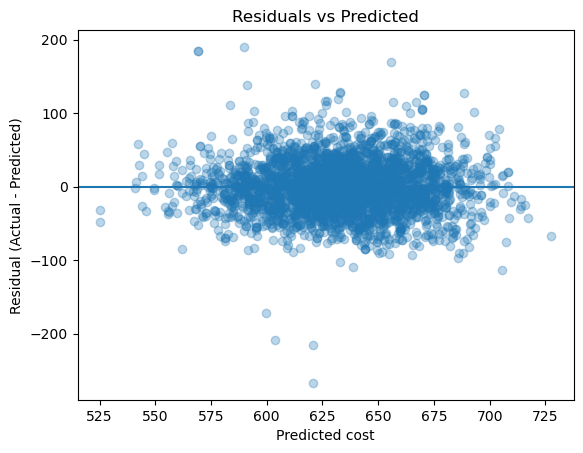

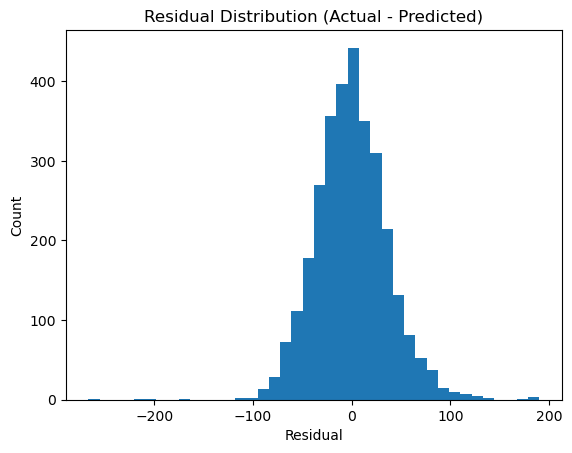

In [33]:
# Residuals vs Predicted
plt.figure()
plt.scatter(results["predicted_cost"], results["residual"], alpha=0.3)
plt.axhline(0)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted cost")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# Residual distribution
plt.figure()
plt.hist(results["residual"], bins=40)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


## 8. Interpreting Coefficients (Top Drivers)

OLS produces a coefficient for each feature:
- **Positive coefficient** → predicted cost increases as that feature increases
- **Negative coefficient** → predicted cost decreases as that feature increases

We rank coefficients by absolute value to find the strongest drivers.


In [36]:
# Map coefficients to feature names (important for interpretation)
coef_table = pd.DataFrame({
    "feature": X_train_clean.columns,
    "coef": ols_model.params,
    "p_value": ols_model.pvalues
})

# Sort by strongest effect size (absolute coefficient)
coef_table["abs_coef"] = coef_table["coef"].abs()
coef_table = coef_table.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"])

print("Top 20 strongest coefficients (by absolute value):")
display(coef_table.head(20))


Top 20 strongest coefficients (by absolute value):


,feature,coef,p_value
0,const,691.507600,0.000000e+00
53,car_value_b,-62.809022,4.215077e-16
54,car_value_c,-50.470274,2.989970e-24
25,state_IA,-49.738094,9.015942e-45
55,car_value_d,-44.087306,1.103326e-20
56,car_value_e,-43.729301,1.358269e-20
57,car_value_f,-43.682153,2.052584e-20
58,car_value_g,-40.223688,3.105838e-17
22,state_DE,39.800324,4.415568e-17
21,state_DC,35.814028,2.665611e-13


## 9. Multicollinearity Check (VIF)

The OLS output flagged a large condition number, which can be caused by **multicollinearity**.

We check multicollinearity using **VIF (Variance Inflation Factor)**:
- **VIF ~ 1**: no multicollinearity
- **VIF > 5**: moderate multicollinearity
- **VIF > 10**: high multicollinearity (coefficients may be unstable)

If VIF is high, we may prefer regularized regression (Ridge/Lasso) for more stable estimates.


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_train_clean.copy()

# VIF can be slow with many dummy variables; limit columns for speed if needed
MAX_COLS = 60
if X_vif.shape[1] > MAX_COLS:
    X_vif = X_vif.iloc[:, :MAX_COLS]

vif_table = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print("Top 20 VIF values:")
display(vif_table.head(20))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''